In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import numpy as np

from yellowbrick.features import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import DiscriminationThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

pd.options.display.max_rows = 100

In [7]:
data = pd.read_csv("heart.csv") # No separate testing set came with this data, it will be split later
o2sat = pd.read_csv("o2Saturation.csv")
data["o2sat"] = o2sat
data.rename(columns={"output" : "ha_chance"}, inplace=True) # rename output to heart attack chance

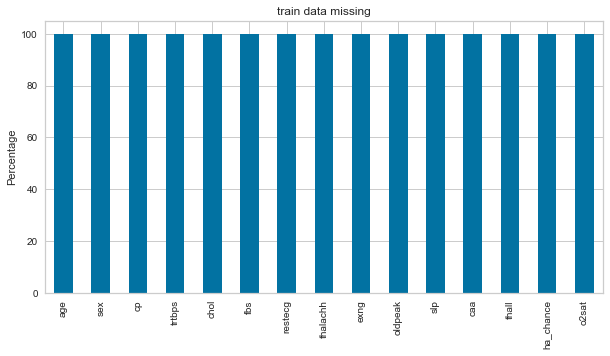

In [8]:
def plot_missing(df, ax, title):
    ax.set_title(title)
    ax.set_ylabel("Percentage")
    (100 - (df.isnull().mean() * 100)).abs().plot.bar(ax=ax)
    
fig, ax = plt.subplots(figsize=(10, 5))
plot_missing(data, ax, "train data missing")

In [9]:
data.shape

(303, 15)

In [10]:
data.describe().round(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,ha_chance,o2sat
count,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000,303.000
mean,54.366,0.683,0.967,131.624,246.264,0.149,0.528,149.647,0.327,1.040,1.399,0.729,2.314,0.545,97.481
std,9.082,0.466,1.032,17.538,51.831,0.356,0.526,22.905,0.470,1.161,0.616,1.023,0.612,0.499,0.347
min,29.000,0.000,0.000,94.000,126.000,0.000,0.000,71.000,0.000,0.000,0.000,0.000,0.000,0.000,96.500
25%,47.500,0.000,0.000,120.000,211.000,0.000,0.000,133.500,0.000,0.000,1.000,0.000,2.000,0.000,97.500
50%,55.000,1.000,1.000,130.000,240.000,0.000,1.000,153.000,0.000,0.800,1.000,0.000,2.000,1.000,97.500
75%,61.000,1.000,2.000,140.000,274.500,0.000,1.000,166.000,1.000,1.600,2.000,1.000,3.000,1.000,97.500
max,77.000,1.000,3.000,200.000,564.000,1.000,2.000,202.000,1.000,6.200,2.000,4.000,3.000,1.000,98.600


In [11]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,ha_chance,o2sat
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,97.5


<AxesSubplot:xlabel='Age', ylabel='Frequency'>

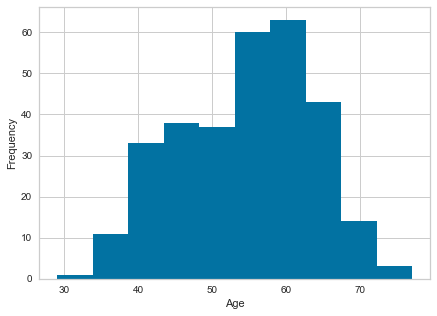

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Age")
data.age.plot(kind="hist", ax=ax)

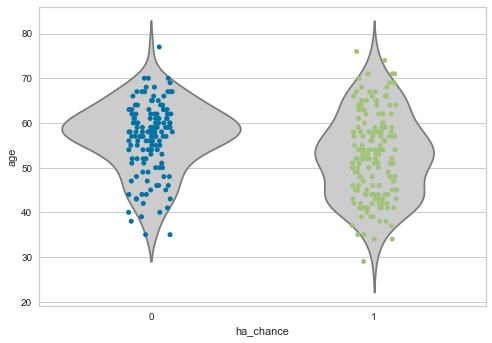

In [13]:
# Age against heart attack chance
ax = sb.violinplot(x="ha_chance", y="age", data=data, inner=None, color=".8")
ax = sb.stripplot(x="ha_chance", y="age", data=data)

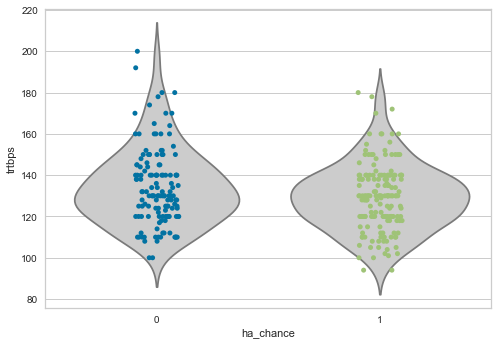

In [14]:
# Resting blood pressure against heart attack chance
ax = sb.violinplot(x="ha_chance", y="trtbps", data=data, inner=None, color=".8")
ax = sb.stripplot(x="ha_chance", y="trtbps", data=data)

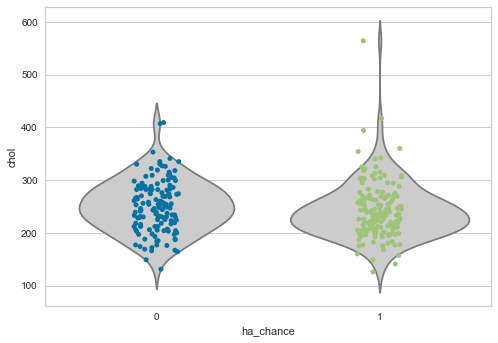

In [15]:
# Blood cholesterol against heart attack chance
ax = sb.violinplot(x="ha_chance", y="chol", data=data, inner=None, color=".8")
ax = sb.stripplot(x="ha_chance", y="chol", data=data)

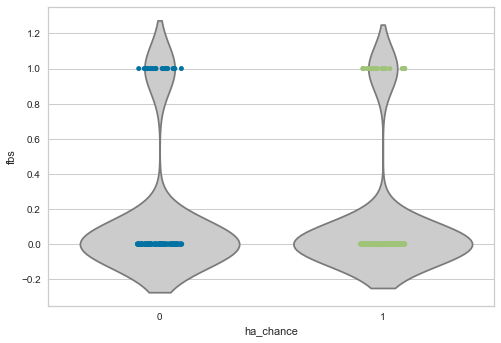

In [16]:
# Fasting blood sugar over 120mg/dl against heart attack chance
ax = sb.violinplot(x="ha_chance", y="fbs", data=data, inner=None, color=".8")
ax = sb.stripplot(x="ha_chance", y="fbs", data=data)

In [17]:
# Pairplot of all the features in the the data saved on disk also
#sb.pairplot(data, hue="ha_chance", kind="reg").savefig("pairplot.png", dpi=300, transparent=False)

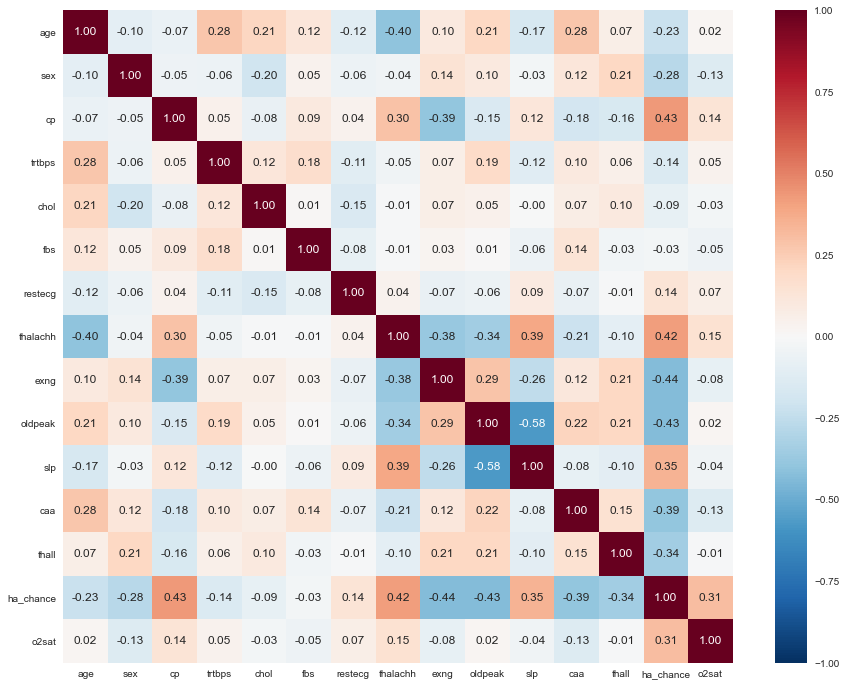

In [18]:
# Pearson correlation
fig, ax = plt.subplots(figsize=(15, 12))
ax = sb.heatmap(
    data.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1
)

In [19]:
# Calculate z-scores for all columns to spot possible outliers
threshold = 3
zscores = stats.zscore(data)
zscores_df = pd.DataFrame(data=zscores, columns=data.columns)
out_mask = zscores_df[zscores_df > threshold].any(axis=1) # Get any columns where there is an outlier
data[out_mask].head() # Sample possible outliers

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,ha_chance,o2sat
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1,98.6
17,66,0,3,150,226,0,1,114,0,2.6,0,0,2,1,98.6


In [20]:
data["max_hr_sur"] = data["thalachh"] > (220 - data["age"]) # Max heart rate surpassed? (normal max heart rate is 220 - age)
data["high_bps"] = data["trtbps"] > 140 # Considered high blood pressure?
data["high_chol"] = data["chol"] > 240 # Considered high cholesterol?
data["avg_ha_sur"] = ((data["sex"] == 1) & (data["age"] > 64.5)) | ((data["sex"] == 0) & (data["age"] > 70.3)) # Is sample at the average heart attack age or above? 64.5 for men, 70.3 for women
data = pd.get_dummies(data, columns=["max_hr_sur", "high_bps", "high_chol", "avg_ha_sur"], drop_first=True)
data.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,ha_chance,o2sat,max_hr_sur_True,high_bps_True,high_chol_True,avg_ha_sur_True
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6,1,0,1,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6,0,0,0,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.1,1,0,0,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,97.5,0,0,1,0


In [21]:
# Reset indices
data = data[out_mask == False]
data.reset_index(drop=True, inplace=True)

In [22]:
# Remove the target labels and check for possible class imbalance
y = data.pop("ha_chance")
y.value_counts()

1    147
0    131
Name: ha_chance, dtype: int64

In [23]:
# Standardize data to mean of 0 and std of 1
scaler = StandardScaler()
data = pd.DataFrame(data=scaler.fit_transform(data), columns=data.columns)
data.describe().round(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,o2sat,max_hr_sur_True,high_bps_True,high_chol_True,avg_ha_sur_True
count,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000,278.000
mean,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.860,-1.507,-0.921,-2.149,-2.568,-0.416,-1.002,-3.410,-0.715,-0.923,-2.388,-0.725,-3.751,-3.444,-0.513,-0.508,-1.007,-0.328
25%,-0.713,-1.507,-0.921,-0.623,-0.725,-0.416,-1.002,-0.746,-0.715,-0.923,-0.699,-0.725,-0.502,0.246,-0.513,-0.508,-1.007,-0.328
50%,0.078,0.664,0.056,-0.037,-0.064,-0.416,0.919,0.128,-0.715,-0.224,-0.699,-0.725,-0.502,0.246,-0.513,-0.508,0.993,-0.328
75%,0.728,0.664,1.034,0.550,0.641,-0.416,0.919,0.696,1.399,0.568,0.990,0.353,1.122,0.246,-0.513,-0.508,0.993,-0.328
max,2.564,0.664,2.011,2.897,3.242,2.404,2.839,2.312,1.399,3.179,0.990,2.509,1.122,2.459,1.948,1.969,0.993,3.049


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)

In [25]:
def get_fe(model): # Get the most important features of given model using recursive feature elimination with KFold cross-validation
    plt.subplots(figsize=(8, 5))
    plt.title(f"RFECV for {type(model).__name__}")
    cv = KFold()
    rfe = RFECV(
        model,
        cv=cv,
        scoring="roc_auc_ovr"
    )
    rfe.fit(X_train, y_train)
    print(f"""Most important features:
{data.columns[rfe.support_]}""")
    rfe.poof()
    return data.columns[rfe.support_]

Most important features:
Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'o2sat', 'max_hr_sur_True',
       'high_bps_True', 'high_chol_True', 'avg_ha_sur_True'],
      dtype='object')


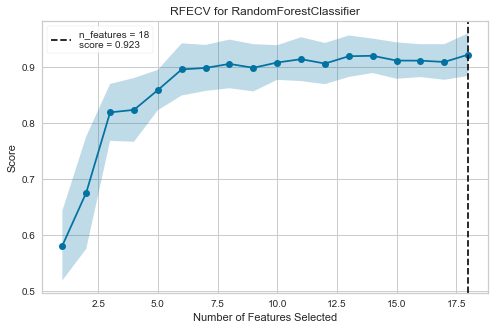

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'o2sat', 'max_hr_sur_True',
       'high_bps_True', 'high_chol_True', 'avg_ha_sur_True'],
      dtype='object')

In [26]:
get_fe(RandomForestClassifier())

Most important features:
Index(['sex', 'cp', 'trtbps', 'chol', 'exng', 'oldpeak', 'slp', 'caa', 'thall',
       'o2sat', 'high_chol_True', 'avg_ha_sur_True'],
      dtype='object')


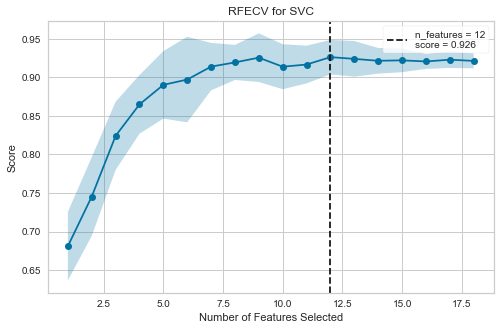

In [27]:
features = get_fe(SVC(kernel="linear", probability=True))

In [28]:
# SVC is the model we'll be using, lets remove the features that are not as important, and then split data again.
data.drop(data.columns.difference([x for x in features]), axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y)
data.head()

,sex,cp,trtbps,chol,exng,oldpeak,slp,caa,thall,o2sat,high_chol_True,avg_ha_sur_True
0,0.663637,0.056246,-0.623475,-0.183033,-0.714751,-0.177410,0.990429,-0.725149,-0.502417,2.459444,-1.007220,-0.327978
1,-1.506847,-0.921029,-0.623475,2.375217,1.399088,-0.363875,0.990429,-0.725149,-0.502417,0.245546,0.992831,-0.327978
2,0.663637,-0.921029,0.550026,-1.136957,-0.714751,-0.550340,-0.698769,-0.725149,-2.126511,0.245546,-1.007220,-0.327978
3,-1.506847,0.056246,0.550026,1.074412,-0.714751,0.288752,-0.698769,-0.725149,-0.502417,0.245546,0.992831,-0.327978
4,0.663637,0.056246,-0.623475,0.402329,-0.714751,-0.923269,0.990429,-0.725149,1.121676,0.245546,0.992831,-0.327978


Most important features:
Index(['cp', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'o2sat'], dtype='object')


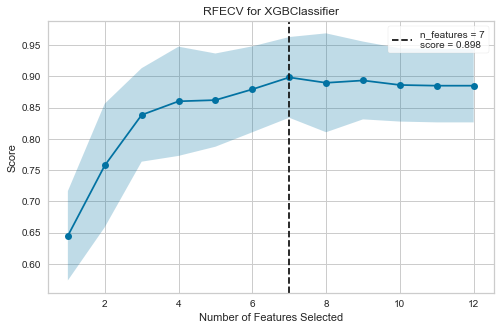

Index(['cp', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'o2sat'], dtype='object')

In [29]:
get_fe(XGBClassifier(use_label_encoder=False, eval_metric="auc"))

Most important features:
Index(['sex', 'cp', 'trtbps', 'chol', 'exng', 'oldpeak', 'slp', 'caa', 'thall',
       'o2sat', 'high_chol_True'],
      dtype='object')


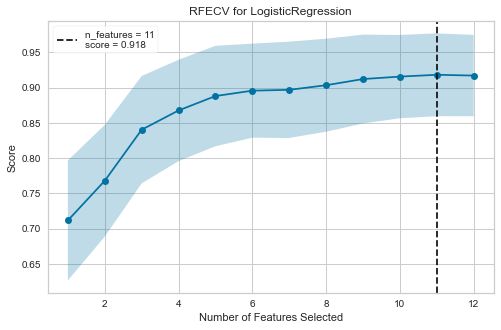

Index(['sex', 'cp', 'trtbps', 'chol', 'exng', 'oldpeak', 'slp', 'caa', 'thall',
       'o2sat', 'high_chol_True'],
      dtype='object')

In [30]:
get_fe(LogisticRegression())

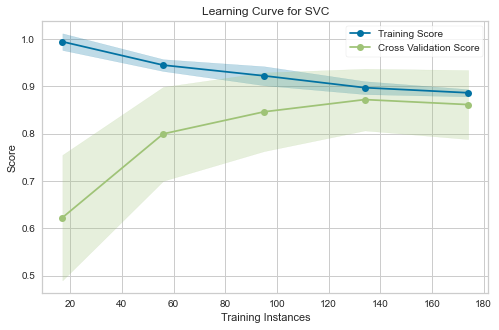

<AxesSubplot:title={'center':'Learning Curve for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [31]:
plt.subplots(figsize=(8, 5))
cv = KFold(n_splits=10)
lc = LearningCurve(SVC(kernel="linear"), cv=cv)
lc.fit(X_train, y_train)
lc.poof()
# We could perhaps be more accurate with more data, unfortunately we can't get more though

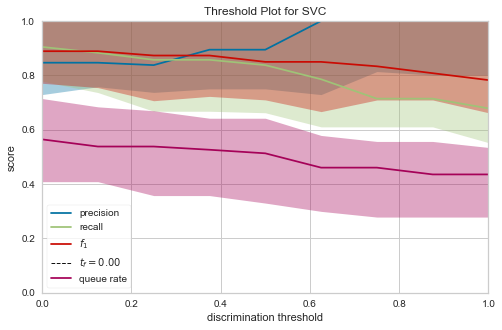

<AxesSubplot:title={'center':'Threshold Plot for SVC'}, xlabel='discrimination threshold', ylabel='score'>

In [32]:
# Plot the discrimination threshold plot, which shows us important classification scores at different model thresholds
# Our aim is to maximize the f1 score, which is the harmonic mean between precision and recall
plt.subplots(figsize=(8, 5))
dt = DiscriminationThreshold(SVC(kernel="linear"), cv=cv)
dt.fit(X_train, y_train)
dt.poof()

In [33]:
# Show the different scores at different discrimination thresholds
dt_df = pd.DataFrame(dt.cv_scores_.values(), index=dt.cv_scores_.keys(), columns=np.round(dt.thresholds_, decimals=3))
dt_df.head(15).round(3)

,0.000,0.125,0.250,0.375,0.500,0.625,0.750,0.875,1.000
recall,0.905,0.883,0.857,0.857,0.838,0.786,0.714,0.714,0.679
recall_lower,0.779,0.737,0.668,0.668,0.663,0.610,0.610,0.610,0.553
recall_upper,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
queue_rate,0.564,0.538,0.538,0.526,0.513,0.461,0.461,0.436,0.436
queue_rate_lower,0.409,0.409,0.358,0.358,0.330,0.300,0.279,0.279,0.279
queue_rate_upper,0.715,0.684,0.670,0.642,0.642,0.579,0.557,0.557,0.535
precision,0.847,0.847,0.838,0.894,0.894,1.000,1.000,1.000,1.000
precision_lower,0.729,0.758,0.737,0.750,0.750,0.729,0.814,0.801,0.801
precision_upper,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
fscore,0.889,0.889,0.873,0.873,0.850,0.850,0.833,0.808,0.783


In [34]:
# Hyperparameter tuning
params = {
    "C" : np.arange(0.1, 2, 0.2),
    "gamma" : np.arange(0.1, 2, 0.2),
    "degree" : np.arange(2, 5, 1),
    "kernel" : ["linear", "rbf", "poly"]
}
clf = SVC()
gscv = GridSearchCV(clf, params, scoring="roc_auc", cv=cv, n_jobs=-1)
gscv.fit(X_train, y_train)
print(f"Best Parameters: {gscv.best_params_}")

Best Parameters: {'C': 0.30000000000000004, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}


In [38]:
clf_final = SVC(**gscv.best_params_)
clf_final.fit(X_train, y_train)
print(f"Final Model Score: {clf_final.score(X_test, y_test)}")

Final Model Score: 0.8571428571428571
